# Notebook Version 2

I made a condensed, and more flexible notebook from out initial. It contains the same processing, but not ass much intermittent reporting making navigation easier. One can of course add code where additional summary reports or graphics is needed. In addition, if the functions generating these reports are in a separate file, this notebook can stay condensed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [2]:
from helpers import outliers_IQR, outliers_z_score, outliers_min_max, handle_outliers, fix_obesity

In [3]:
np.random.seed(2023)

In [4]:
diabetes = pd.read_csv('diabetes.csv')

binary_features = ['Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness',
                   'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching',
                   'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia']
cat_features = ['Race',	'Occupation',	'GP']
num_features = ['Age',	'Height',	'Weight',	'Temperature',	'Urination']
one_hot_features = {} # for future use
diabetes.info()
print("Found:", len(cat_features+binary_features+num_features)+1) # +1 for Gender
print("In DS:", diabetes.shape[1]-1) # -1 for target


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 534 non-null    float64
 1   Gender              542 non-null    object 
 2   Race                537 non-null    object 
 3   Occupation          534 non-null    object 
 4   GP                  539 non-null    object 
 5   Height              538 non-null    float64
 6   Weight              541 non-null    float64
 7   Obesity             538 non-null    object 
 8   Temperature         546 non-null    float64
 9   Urination           532 non-null    float64
 10  TCep                546 non-null    object 
 11  Polydipsia          540 non-null    object 
 12  Sudden Weight Loss  530 non-null    object 
 13  Weakness            541 non-null    object 
 14  Polyphagia          544 non-null    object 
 15  Genital Thrush      538 non-null    object 
 16  Visual B

## Uniform formatting

In [5]:

# Converts all binary features to lower case
for f in binary_features:
   diabetes[f] = diabetes[f].str.lower()

# Converts all binary features to ints, preserving Na-s
diabetes = diabetes.replace({'yes':1, 'no':0}) 
diabetes = diabetes.replace({'Positive':1, 'Negative':0}) 

## Duplicates

We identify duplicates and delete them. We assume they are caused by an error in the data collection, and it's unlikely that there are two correct instances with the exact same values.  



In [6]:
diabetes = diabetes.drop_duplicates(keep='first')

## Meters to centimeters

In [7]:
# Converts meter to centimeter
condition = diabetes['Height'] < 100
diabetes.loc[condition, ['Height']] = diabetes.loc[condition, ['Height']].mul(100)


## Missing categorical data
If we don't fill missing categorical data now, we run the risk that either the train or the test set don't contain any NA-s. This can cause a difference in columns after one hot encoding and lead to a crash.

In [8]:
# we want to fill early s.t. there are no Na-s beyond this point
diabetes[cat_features + ['Gender']] = diabetes[cat_features+ ['Gender']].fillna('MISSING') 


# Summary reports

# Preliminary Data analysis

# Train - Test split
We split as early as possible to avoid cross contamination of information from the test set.

In [9]:
train_proportion = 0.8
train_idx = np.random.choice(diabetes.index, int(train_proportion*len(diabetes.index)), replace=False)
train = diabetes.loc[train_idx]
test = diabetes.drop(train_idx)
assert len(diabetes.index) == len(train.index) + len(test.index)

## Outliers

In [10]:
age_min, age_max = outliers_IQR(train, 'Age')
age_min2, age_max2 = outliers_z_score(train, 'Age')

print("IQR:", age_min, age_max)
print("Z-score:", age_min2, age_max2)
outliers_min_max(train, 'Age', age_min, age_max)

IQR: 12.0 84.0
Z-score: -13.129932425306258 110.61141390678773


,Age,Gender,Race,Occupation,GP,Height,Weight,Obesity,Temperature,Urination,...,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
416,90.0,Female,White,Retired,Dr. Mayson Harris,163.50,50.75,0.0,36.97,1.42,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1
399,-22.0,Male,White,Dentist,Dr. Ingrid Mata,174.25,71.10,0.0,36.96,2.63,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
449,377.0,Male,White,Consultant,Dr. Angharad Grainger,169.31,68.32,0.0,37.23,1.90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
20,90.0,Female,White,Retired,Dr. Andreea Gregory,165.87,67.48,0.0,36.86,NaN,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1


In [11]:

print("Before removal of outliers:", train.shape)
train = handle_outliers(train)
test = handle_outliers(test)
print("After removal of outliers:", train.shape)

# How does it look now? All min max values sensible ...
train.describe()

Before removal of outliers: (416, 24)
After removal of outliers: (416, 24)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes
count,403.000000,408.000000,412.000000,412.000000,416.000000,401.000000,416.000000,410.000000,404.000000,412.000000,414.000000,409.000000,413.000000,413.000000,412.000000,411.000000,403.000000,407.000000,408.000000,416.000000
mean,48.101737,168.667892,69.416748,0.155340,37.002187,2.285087,0.420673,0.463415,0.408416,0.587379,0.454106,0.210269,0.450363,0.481840,0.245146,0.469586,0.436725,0.371007,0.360294,0.629808
std,12.105550,10.391145,15.600117,0.362669,0.201253,0.687902,0.494262,0.499269,0.492150,0.492904,0.498492,0.407999,0.498134,0.500276,0.430697,0.499682,0.496597,0.483669,0.480675,0.483437
min,16.000000,141.360000,40.350000,0.000000,36.450000,0.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,161.735000,57.747500,0.000000,36.860000,1.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,169.555000,66.980000,0.000000,37.000000,2.580000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,56.500000,176.327500,79.830000,0.000000,37.150000,2.890000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,193.950000,125.950000,1.000000,37.440000,3.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing data

In [12]:
def check_missing_data(df):
  print(df.isna().sum().sort_values(ascending=False))
  print(df.isna().mean().sort_values(ascending=False))
  print("Total number of missing data:", df.isna().sum().sum())
  print("Percentage of missing data:", df.isna().mean().mean())
  print("Samples with at least one missing value:", len(df[df.isnull().any(axis=1)]))
  print("Percentage samples with at least one missing value:", len(df[df.isnull().any(axis=1)])/len(df))

check_missing_data(train)

Urination             15
Age                   13
Partial Paresis       13
Sudden Weight Loss    12
Muscle Stiffness       9
Alopecia               8
Height                 8
Genital Thrush         7
Polydipsia             6
Delayed Healing        5
Irritability           4
Weight                 4
Obesity                4
Weakness               4
Visual Blurring        3
Itching                3
Polyphagia             2
Race                   0
GP                     0
Gender                 0
TCep                   0
Occupation             0
Temperature            0
Diabetes               0
dtype: int64
Urination             0.036058
Age                   0.031250
Partial Paresis       0.031250
Sudden Weight Loss    0.028846
Muscle Stiffness      0.021635
Alopecia              0.019231
Height                0.019231
Genital Thrush        0.016827
Polydipsia            0.014423
Delayed Healing       0.012019
Irritability          0.009615
Weight                0.009615
Obesity        

In [13]:
# missing more than 2
for i in train[train.isna().sum(axis=1) > 2].index:
  print(train.loc[i,])

Age                              34.0
Gender                         Female
Race                            White
Occupation                    Dentist
GP                    Dr. Albie Colon
Height                         156.04
Weight                          47.94
Obesity                           0.0
Temperature                      37.1
Urination                        2.79
TCep                                0
Polydipsia                        NaN
Sudden Weight Loss                NaN
Weakness                          1.0
Polyphagia                        0.0
Genital Thrush                    0.0
Visual Blurring                   0.0
Itching                           0.0
Irritability                      1.0
Delayed Healing                   0.0
Partial Paresis                   NaN
Muscle Stiffness                  1.0
Alopecia                          0.0
Diabetes                            1
Name: 187, dtype: object


### Derived Features

In [14]:
train = fix_obesity(train)
test = fix_obesity(test)

### Missing Binaries

In [15]:
train[binary_features] = train[binary_features].fillna(0)
test[binary_features] = test[binary_features].fillna(0)

### Missing Categorical

It makes no sense to consider 'Gender' as a binary feature where we can default it to 0. In addition, there might exist a gender bias in the data collection, and including it as missing might mitigate or reveal it later.

### Missing numeric

In [16]:
# Fill Na-s with mean. 
train[num_features] = train[num_features].fillna(train[num_features].mean())
# We fill the test data with the mean of the train data, making the test set indepentent of each others
test[num_features] = test[num_features].fillna(train[num_features].mean())

### Testing for remaining Na-s

In [17]:
assert train.isna().sum().sum() == 0, f'train data still containts {train.isna().sum().sum()} Na-s'
assert test.isna().sum().sum() == 0, f'test data still containts {test.isna().sum().sum()} Na-s'

Henceforth, we may assume both train and test data contains no Na-s, drastically simplifying the rest of the code. For online learning, we should perhaps implement the code in this section as a function so that we can apply it on new cases continuously.

## Encoding

In [18]:
gender_dummies_train = pd.get_dummies(train['Gender'], prefix='gender')
train = train.join(gender_dummies_train)

gender_dummies_test = pd.get_dummies(test['Gender'], prefix='gender')

test = test.join(gender_dummies_test)

one_hot_features['Gender'] = list(set(list(gender_dummies_train.columns) + list(gender_dummies_test.columns)))

In [19]:
# Add one hot variable column to train/test if it exists for one, but not the other adn fill with 0
for i in list(gender_dummies_train):
    if i not in gender_dummies_test:
        test[i] = 0

for i in list(gender_dummies_test):
    if i not in gender_dummies_train:
        train[i] = 0

In [20]:
def checkEqualColumns(L1, L2):
    return len(L1) == len(L2) and sorted(L1) == sorted(L2)

In [21]:
assert checkEqualColumns(train.columns, test.columns), f'train and test set doesent have the same features'

In [22]:
for i in zip(sorted(train.columns), sorted(test.columns)):
    print(i)

('Age', 'Age')
('Alopecia', 'Alopecia')
('Delayed Healing', 'Delayed Healing')
('Diabetes', 'Diabetes')
('GP', 'GP')
('Gender', 'Gender')
('Genital Thrush', 'Genital Thrush')
('Height', 'Height')
('Irritability', 'Irritability')
('Itching', 'Itching')
('Muscle Stiffness', 'Muscle Stiffness')
('Obesity', 'Obesity')
('Occupation', 'Occupation')
('Partial Paresis', 'Partial Paresis')
('Polydipsia', 'Polydipsia')
('Polyphagia', 'Polyphagia')
('Race', 'Race')
('Sudden Weight Loss', 'Sudden Weight Loss')
('TCep', 'TCep')
('Temperature', 'Temperature')
('Urination', 'Urination')
('Visual Blurring', 'Visual Blurring')
('Weakness', 'Weakness')
('Weight', 'Weight')
('gender_Female', 'gender_Female')
('gender_MISSING', 'gender_MISSING')
('gender_Male', 'gender_Male')


## Correlations

In [23]:
corr = train.corr(numeric_only=True)
#corr['Diabetes']
#sns.heatmap(corr)

# look at the smallest and largest in absolute value
cmap = 'coolwarm' # Added colour map as a variable for consistent plot style
corrs = corr.stack().loc[lambda x : (x < 1)].abs().sort_values()
print("Smallest:")
print(corrs[:20])
print("-------------------------------")
print("Largest:")
print(corrs[-20:])
corr.style.background_gradient(cmap=cmap).set_precision(2)

Smallest:
Age              gender_MISSING     0.003116
gender_MISSING   Age                0.003116
Visual Blurring  Weight             0.003154
Weight           Visual Blurring    0.003154
gender_MISSING   Alopecia           0.003572
Alopecia         gender_MISSING     0.003572
                 Temperature        0.005215
Temperature      Alopecia           0.005215
Obesity          Alopecia           0.005361
Alopecia         Obesity            0.005361
gender_MISSING   Temperature        0.006139
Temperature      gender_MISSING     0.006139
Weight           TCep               0.006390
TCep             Weight             0.006390
Itching          Diabetes           0.006660
Diabetes         Itching            0.006660
Genital Thrush   Weakness           0.012381
Weakness         Genital Thrush     0.012381
Genital Thrush   Temperature        0.012458
Temperature      Genital Thrush     0.012458
dtype: float64
-------------------------------
Largest:
Diabetes         Partial Paresis  

/var/folders/ps/_kmvj3_s5w5109d0211tgc9r0000gn/T/ipykernel_39818/931123861.py:13: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap=cmap).set_precision(2)


,Age,Height,Weight,Obesity,Temperature,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Genital Thrush,Visual Blurring,Itching,Irritability,Delayed Healing,Partial Paresis,Muscle Stiffness,Alopecia,Diabetes,gender_Female,gender_MISSING,gender_Male
Age,1.00,0.05,0.13,0.15,0.02,0.18,-0.10,0.12,0.04,0.18,0.28,0.06,0.40,0.28,0.23,0.25,0.23,0.31,0.34,0.12,-0.05,-0.00,0.05
Height,0.05,1.00,0.53,-0.03,-0.03,-0.26,0.05,-0.26,-0.21,-0.14,-0.15,0.18,-0.16,-0.04,-0.03,-0.10,-0.24,-0.07,0.22,-0.31,-0.72,-0.01,0.72
Weight,0.13,0.53,1.00,0.57,0.03,-0.02,-0.01,-0.04,-0.03,-0.04,-0.06,0.18,0.00,0.02,0.08,-0.07,-0.13,0.07,0.15,-0.11,-0.36,-0.03,0.36
Obesity,0.15,-0.03,0.57,1.00,0.07,0.14,-0.04,0.05,0.19,0.04,0.03,0.11,0.10,-0.02,0.15,-0.09,-0.01,0.18,0.01,0.08,0.01,0.04,-0.02
Temperature,0.02,-0.03,0.03,0.07,1.00,0.07,-0.05,0.07,0.06,0.03,0.06,0.01,0.02,-0.03,0.05,0.05,0.01,0.02,0.01,0.08,0.04,0.01,-0.04
Urination,0.18,-0.26,-0.02,0.14,0.07,1.00,-0.29,0.53,0.38,0.23,0.36,0.05,0.21,0.07,0.21,0.09,0.41,0.13,-0.15,0.62,0.28,0.05,-0.28
TCep,-0.10,0.05,-0.01,-0.04,-0.05,-0.29,1.00,-0.30,-0.17,-0.15,-0.15,-0.03,-0.13,-0.08,-0.16,-0.02,-0.22,-0.06,0.07,-0.48,-0.15,-0.02,0.16
Polydipsia,0.12,-0.26,-0.04,0.05,0.07,0.53,-0.30,1.00,0.37,0.33,0.31,0.03,0.32,0.13,0.19,0.11,0.43,0.18,-0.32,0.65,0.32,-0.02,-0.31
Sudden Weight Loss,0.04,-0.21,-0.03,0.19,0.06,0.38,-0.17,0.37,1.00,0.21,0.19,0.02,0.04,-0.02,0.14,0.04,0.27,0.08,-0.21,0.40,0.28,0.11,-0.30
Weakness,0.18,-0.14,-0.04,0.04,0.03,0.23,-0.15,0.33,0.21,1.00,0.15,-0.01,0.29,0.26,0.16,0.32,0.25,0.28,0.09,0.24,0.12,0.01,-0.12


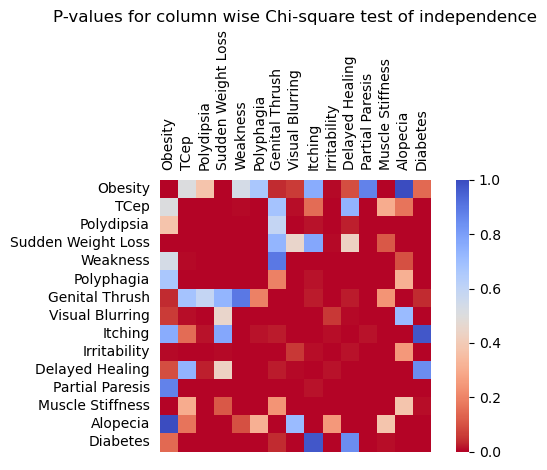

In [24]:
import matplotlib
from helpers import plot_chi_square_p_values

# reverse color as low p-value indicates strong dependence
plot_chi_square_p_values(train[binary_features + ['Diabetes']], kwargs={'cmap' : matplotlib.colormaps[cmap +'_r']}, outfile = 'images/cat_cat_corr.png')


Common sense can replace domain experts, in some cases - Roxana Pop, i.e. we should not use 'TCep' for our analysis (even though delayed healing might be correlated with aversion for tattoos)


In [25]:
from biseral_correlation import plot_point_biserial_correlation

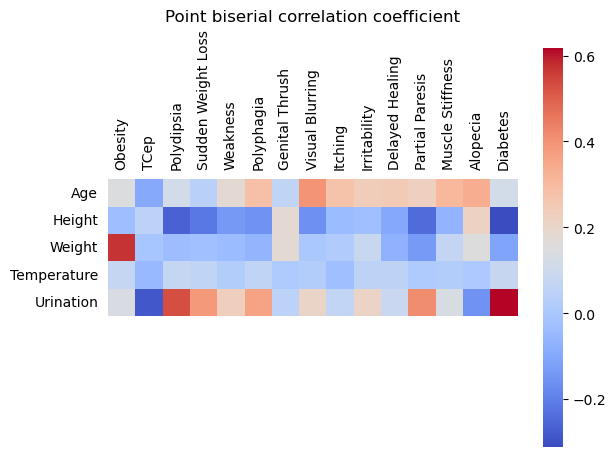

In [26]:
plot_point_biserial_correlation(train, cont=num_features, cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap}, outfile='images/cont_cat_corr.png')

In [27]:
from helpers import BMI

train['BMI'] = BMI(train['Weight'],  train['Height'])

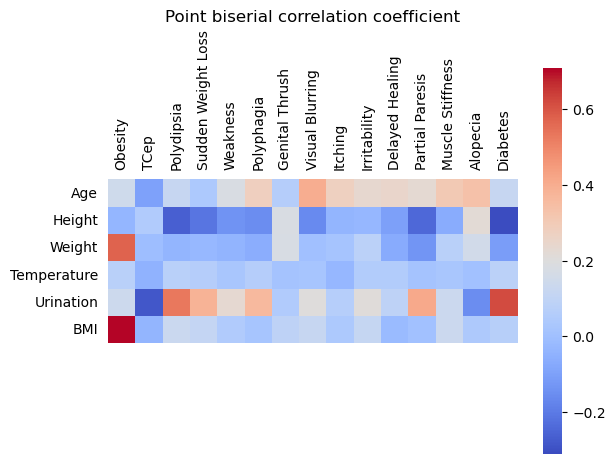

In [50]:
plot_point_biserial_correlation(train, cont=num_features + ['BMI'], cat=binary_features + ['Diabetes'], kwargs={'cmap' : cmap}, outfile = 'images/cont_cat_corr_bmi.png')

 We see that weight and obesity is strongly correlated, however BMI and obesity is not. Furthermore, diabetes has no correlation with either of them. This does not mean that BMI or weight are bad predictors, since the relationship between them could be non-linear. 

 Urination is indeed very correlated, which is apparent in the later plots.

## Data exploration

In [29]:
# There are some interesting things to see in the categoricals ...
# Only one Black in entire data set ...
# This looks very much like a rich person data set ...
for c in cat_features:
  print(train.groupby(c, dropna=False).size())

#print(train['GP'].unique())

Race
Asian        6
MISSING      8
White      402
dtype: int64
Occupation
Architect        27
Consultant       30
Dentist          33
Economist        30
Engineer         23
Entrepreneur     23
Journalist       22
Judge            36
Lawyer           28
MISSING          11
Manager          34
Retired         118
Student           1
dtype: int64
GP
Dr. Albie Colon          26
Dr. Alice Watson         19
Dr. Andreea Gregory      25
Dr. Angharad Grainger    19
Dr. Arda O'Brien         20
Dr. Cristiano Ayala      13
Dr. Dominic Farmer       18
Dr. Ingrid Mata          19
Dr. Jamil Walters        16
Dr. Joshua Riley         26
Dr. Kameron Lancaster    27
Dr. Kason Lloyd          18
Dr. Khalid Sellers       21
Dr. Korey Clay           25
Dr. Lina Beech           18
Dr. Lorelai York         20
Dr. Madison Guy          28
Dr. Mayson Harris        19
Dr. Nial Higgs           18
Dr. Orla Arellano        16
MISSING                   5
dtype: int64


Polydipsia
0.0    1.956175
1.0    2.676319
Name: Urination, dtype: float64


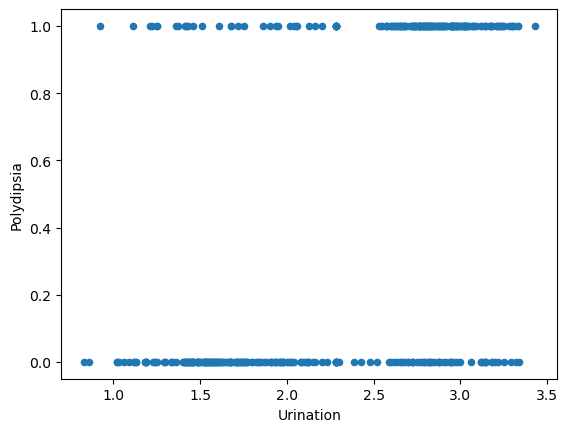

In [30]:
train.plot.scatter('Urination', 'Polydipsia')
print(train.groupby('Polydipsia')['Urination'].mean())

<Axes: ylabel='Frequency'>

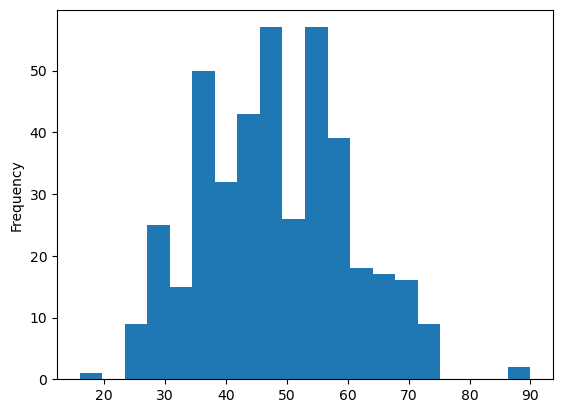

In [31]:
train['Age'].plot.hist(bins=20)

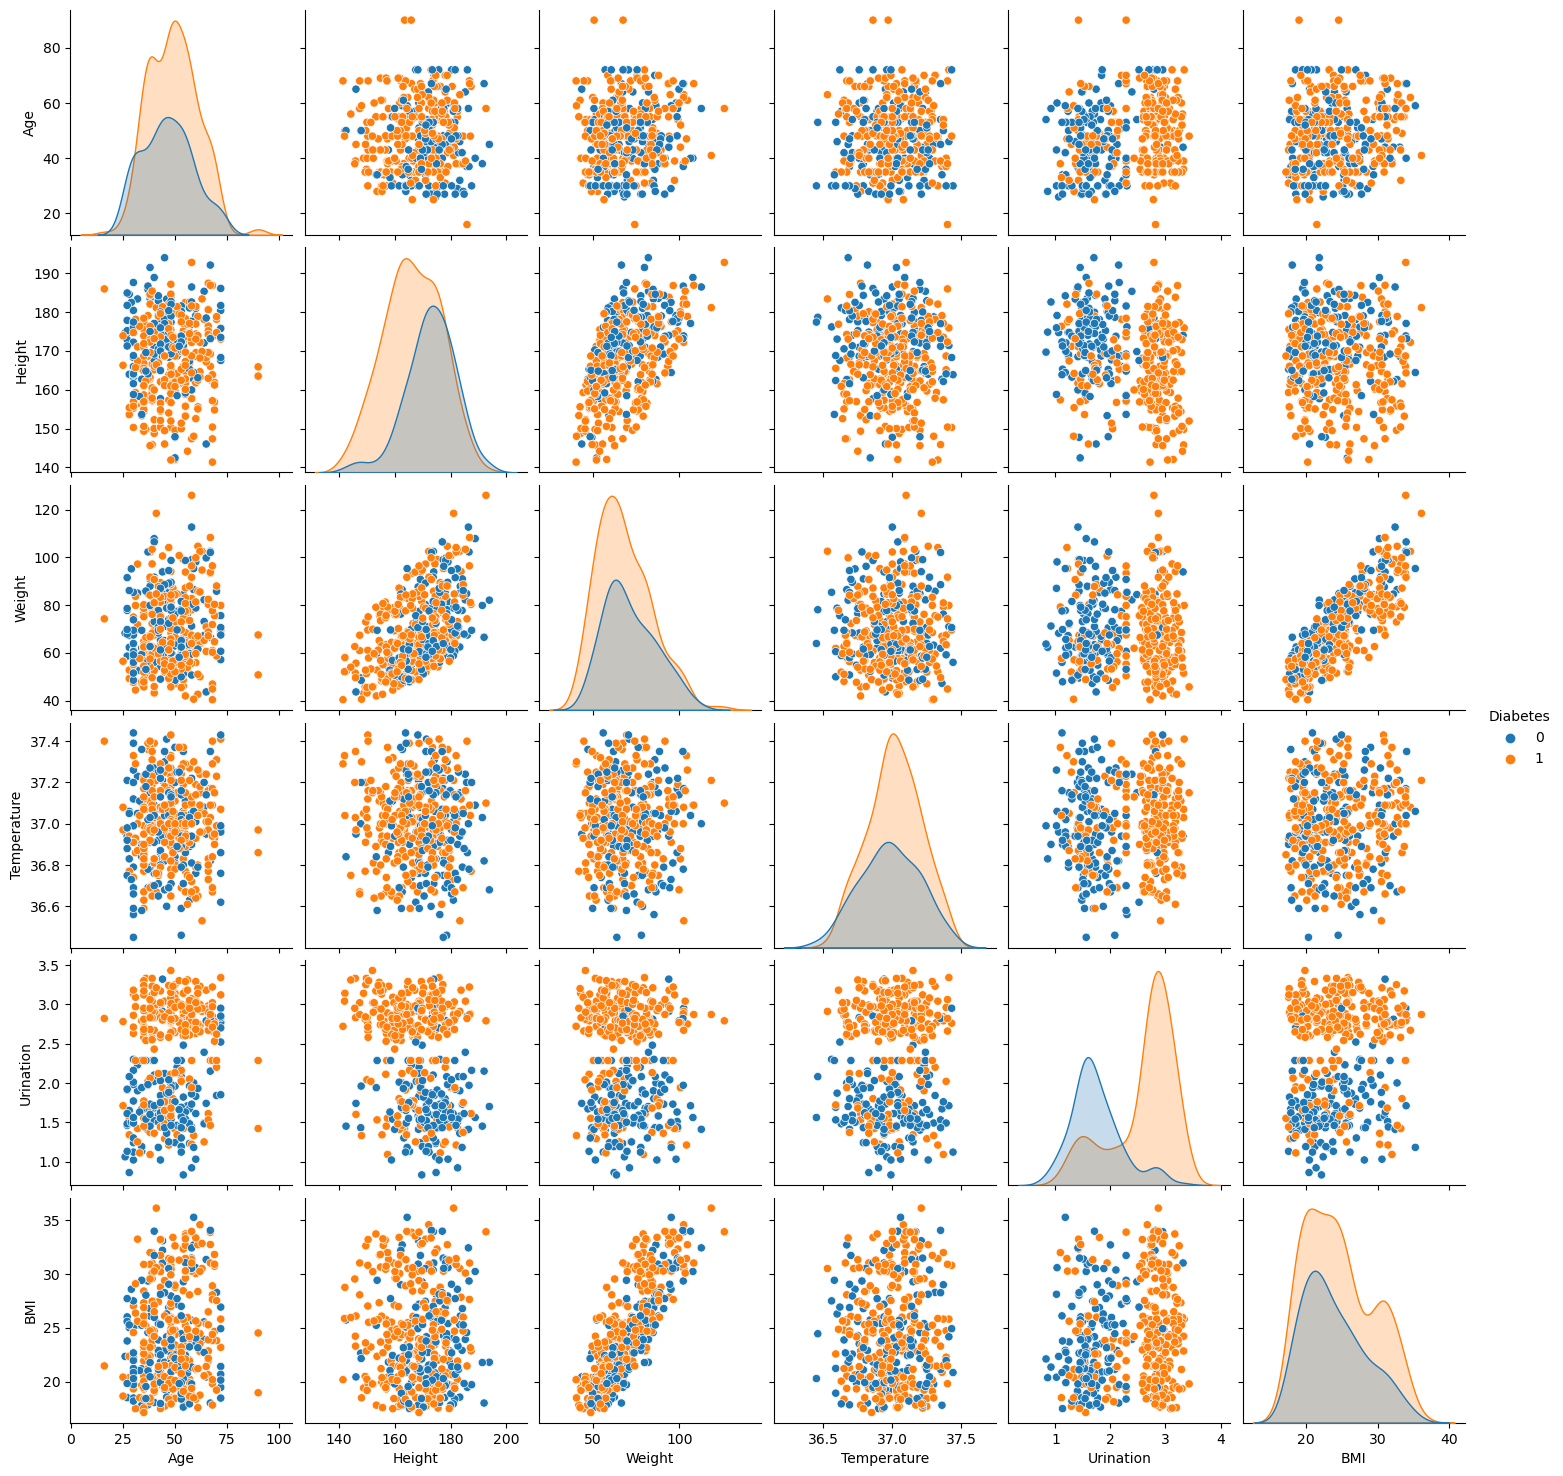

In [32]:
# After encoding, pair-plotting diabetes is messed up, because it tries to make 23*23 plots?
# need to drop the binaries from DF plotted.
# train_plot = train.drop(binary_features , axis=1)
train_plot = train[num_features + ['BMI', 'Diabetes']]

#diabetes_plot = train.drop('Gender', axis=1)
g = sns.pairplot(train_plot, hue='Diabetes')

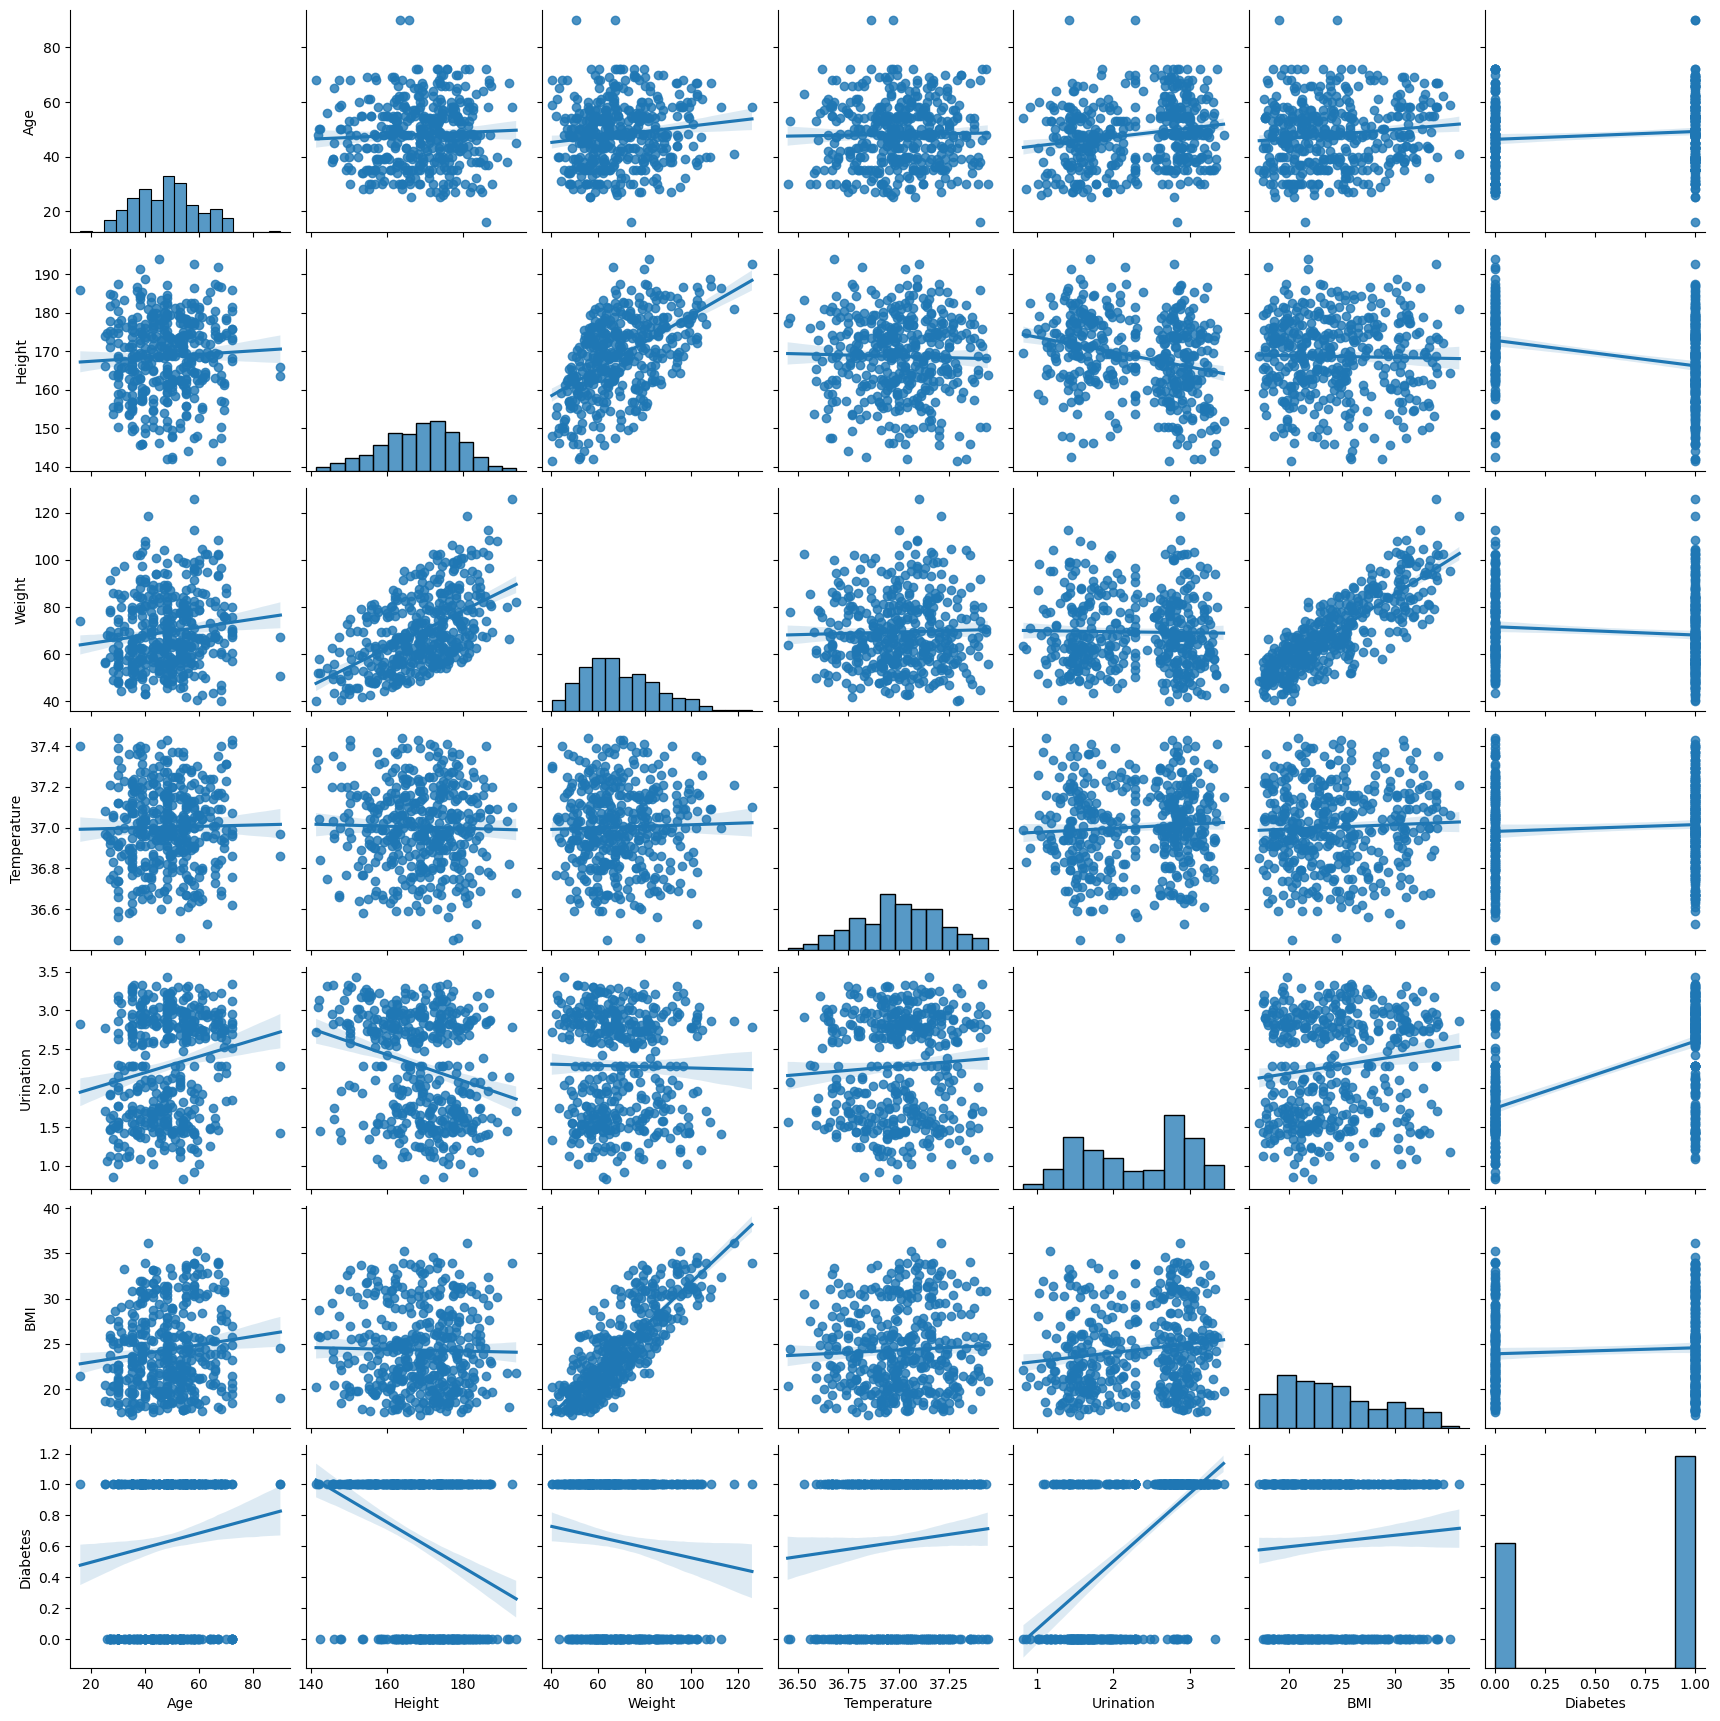

In [33]:
g = sns.pairplot(train_plot, kind='reg')

In [34]:
# Perhaps redundant given the chi-square plot earlier?
for f in binary_features:
  cross_tab = pd.crosstab(diabetes[f], diabetes['Diabetes'], rownames=[f], colnames=['Diabetes'])
  print(cross_tab)
  print('-----------------------')

Diabetes    0    1
Obesity           
0.0       171  264
1.0        25   53
-----------------------
Diabetes    0    1
TCep              
0          54  243
1         146   77
-----------------------
Diabetes      0    1
Polydipsia          
0.0         190   94
1.0           8  222
-----------------------
Diabetes              0    1
Sudden Weight Loss          
0.0                 169  127
1.0                  29  181
-----------------------
Diabetes    0    1
Weakness          
0.0       110  100
1.0        87  218
-----------------------
Diabetes      0    1
Polyphagia          
0.0         151  131
1.0          48  188
-----------------------
Diabetes          0    1
Genital Thrush          
0.0             163  236
1.0              31   82
-----------------------
Diabetes           0    1
Visual Blurring          
0.0              140  144
1.0               58  174
-----------------------
Diabetes    0    1
Itching           
0.0       100  165
1.0        95  154
----------------

# Training model

In [35]:
# Some sanity checks
assert train.isna().sum().sum() == 0, 'No Na-s should be present after handling. They must have been introduced'

#selected_features = ['Urination', 'Age'] + binary_features
selected_features = num_features + binary_features + one_hot_features['Gender'] 
print(selected_features)
print(len(selected_features))

# This is so stupid ... Never mind, Decision tree does not seem to care if X is series or DF ...
# Naive Bayes does, I think ...
#if len(selected_features) == 1:
#  X_train = train2[[selected_features[0]]]
#else:
X_train = train[selected_features]
y_train = train['Diabetes']

# Test set
X_test = test[selected_features]
y_test = test['Diabetes']


for index in X_train.dtypes.keys():
    dtype = X_train.dtypes[index]
    print(index, dtype)
    # Quite ugly and not very felxible test. Should be improved upon
    assert dtype == 'float64' or dtype == 'int64' or dtype == 'uint8', f"feature '{index}' is not of type float or int but {dtype}"


['Age', 'Height', 'Weight', 'Temperature', 'Urination', 'Obesity', 'TCep', 'Polydipsia', 'Sudden Weight Loss', 'Weakness', 'Polyphagia', 'Genital Thrush', 'Visual Blurring', 'Itching', 'Irritability', 'Delayed Healing', 'Partial Paresis', 'Muscle Stiffness', 'Alopecia', 'gender_Male', 'gender_MISSING', 'gender_Female']
22
Age float64
Height float64
Weight float64
Temperature float64
Urination float64
Obesity float64
TCep int64
Polydipsia float64
Sudden Weight Loss float64
Weakness float64
Polyphagia float64
Genital Thrush float64
Visual Blurring float64
Itching float64
Irritability float64
Delayed Healing float64
Partial Paresis float64
Muscle Stiffness float64
Alopecia float64
gender_Male uint8
gender_MISSING uint8
gender_Female uint8


Age : 16.560009729196118
Height : 25.14859572787318
Weight : 17.127505701099814
Temperature : 0.002901403988647537
Urination : 31.517555474070342
Obesity : 2.1715078814315465
TCep : 54.6400832755031
Polydipsia : 96.3658800018784
Sudden Weight Loss : 39.70345328971284
Weakness : 9.860017844750669
Polyphagia : 25.75051519862305
Genital Thrush : 3.89431019894361
Visual Blurring : 14.246432382359504
Itching : 0.0096253050720045
Irritability : 31.85730579601036
Delayed Healing : 0.04653863717266018
Partial Paresis : 47.51044098164155
Muscle Stiffness : 4.726094238404035
Alopecia : 16.225521635242774
gender_Male : 26.93419305276036
gender_MISSING : 1.7633587786259541
gender_Female : 44.67881695912231


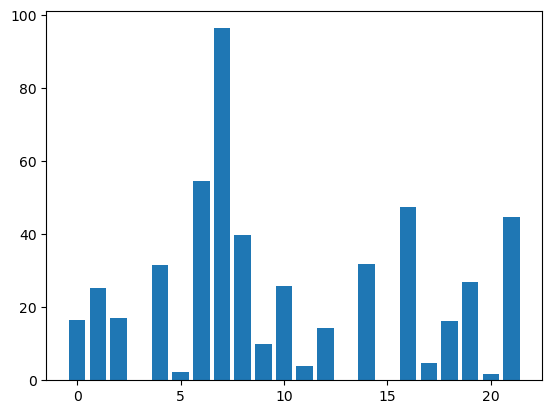

,Age,Height,Weight,Urination,TCep,Polydipsia,Sudden Weight Loss,Weakness,Polyphagia,Visual Blurring,Irritability,Partial Paresis,Alopecia,gender_Male,gender_Female
24,64.0,185.300000,82.17,2.39,1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1,0
308,43.0,176.930000,65.45,1.84,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
177,48.0,164.620000,69.06,2.88,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,1
184,48.0,168.667892,73.59,2.65,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0
4,30.0,155.230000,48.16,3.13,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,72.0,173.450000,60.64,1.85,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1,0
427,16.0,185.920000,74.22,2.82,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0
370,40.0,173.110000,90.69,1.36,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0
55,52.0,171.170000,58.13,1.66,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0


In [36]:
from sklearn.feature_selection import SelectKBest, chi2
skb =  SelectKBest(chi2, k=15)
X_new = skb.fit_transform(X_train, y_train)

cols_idxs = skb.get_support(indices=True)
features_df_new = X_train.iloc[:,cols_idxs]



# what are scores for the features
for i in range(len(skb.scores_)):
 print(X_train.columns[i], ":", skb.scores_[i])
# plot the scores
plt.bar([i for i in range(len(skb.scores_))], skb.scores_)
plt.show()
features_df_new

Decision tree with depth=1. cv score: 0.7475616752725187
Decision tree with depth=2. cv score: 0.8366322432587493
Decision tree with depth=3. cv score: 0.8414515203671831
Decision tree with depth=4. cv score: 0.891853126792886
Decision tree with depth=5. cv score: 0.8629661503155479
Decision tree with depth=6. cv score: 0.8871199082042456
Decision tree with depth=7. cv score: 0.8919965576592082
Decision tree with depth=8. cv score: 0.8847389558232932
Decision tree with depth=9. cv score: 0.8895295467584624
Decision tree with depth=10. cv score: 0.8894434882386688
Decision tree with depth=11. cv score: 0.8774813539873779
Decision tree with depth=12. cv score: 0.8846815834767641
Decision tree with depth=13. cv score: 0.879890992541595
Decision tree with depth=14. cv score: 0.88714859437751
Decision tree with depth=15. cv score: 0.8774813539873779
Decision tree with depth=16. cv score: 0.8774813539873781
Decision tree with depth=17. cv score: 0.8918818129661503
Decision tree with depth=18

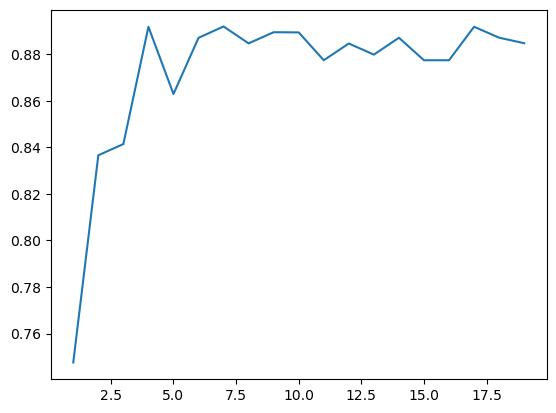

In [37]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

depths = list(range(1, 20))

scores = {}

"""
By weighing misslcassification more severly, we can minimze type II error,
which is desirable in the public health scenario. However, even with
a very skewed weighing (1-100), we still get missclassification,
indicatting that there are 'outliers' in the test set.

Further investigation revealed that they typically where quite old or quite young,
with a typical amount of urination.
"""
weight = {0: 1,
          1:2}

use_weights = True

for d in depths:
    clf_cv = tree.DecisionTreeClassifier(max_depth=d, class_weight=weight if use_weights else None)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Decision tree with depth={d}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())

clf = tree.DecisionTreeClassifier(max_depth=7, class_weight=weight if use_weights else None)
clf = clf.fit(X_train, y_train)

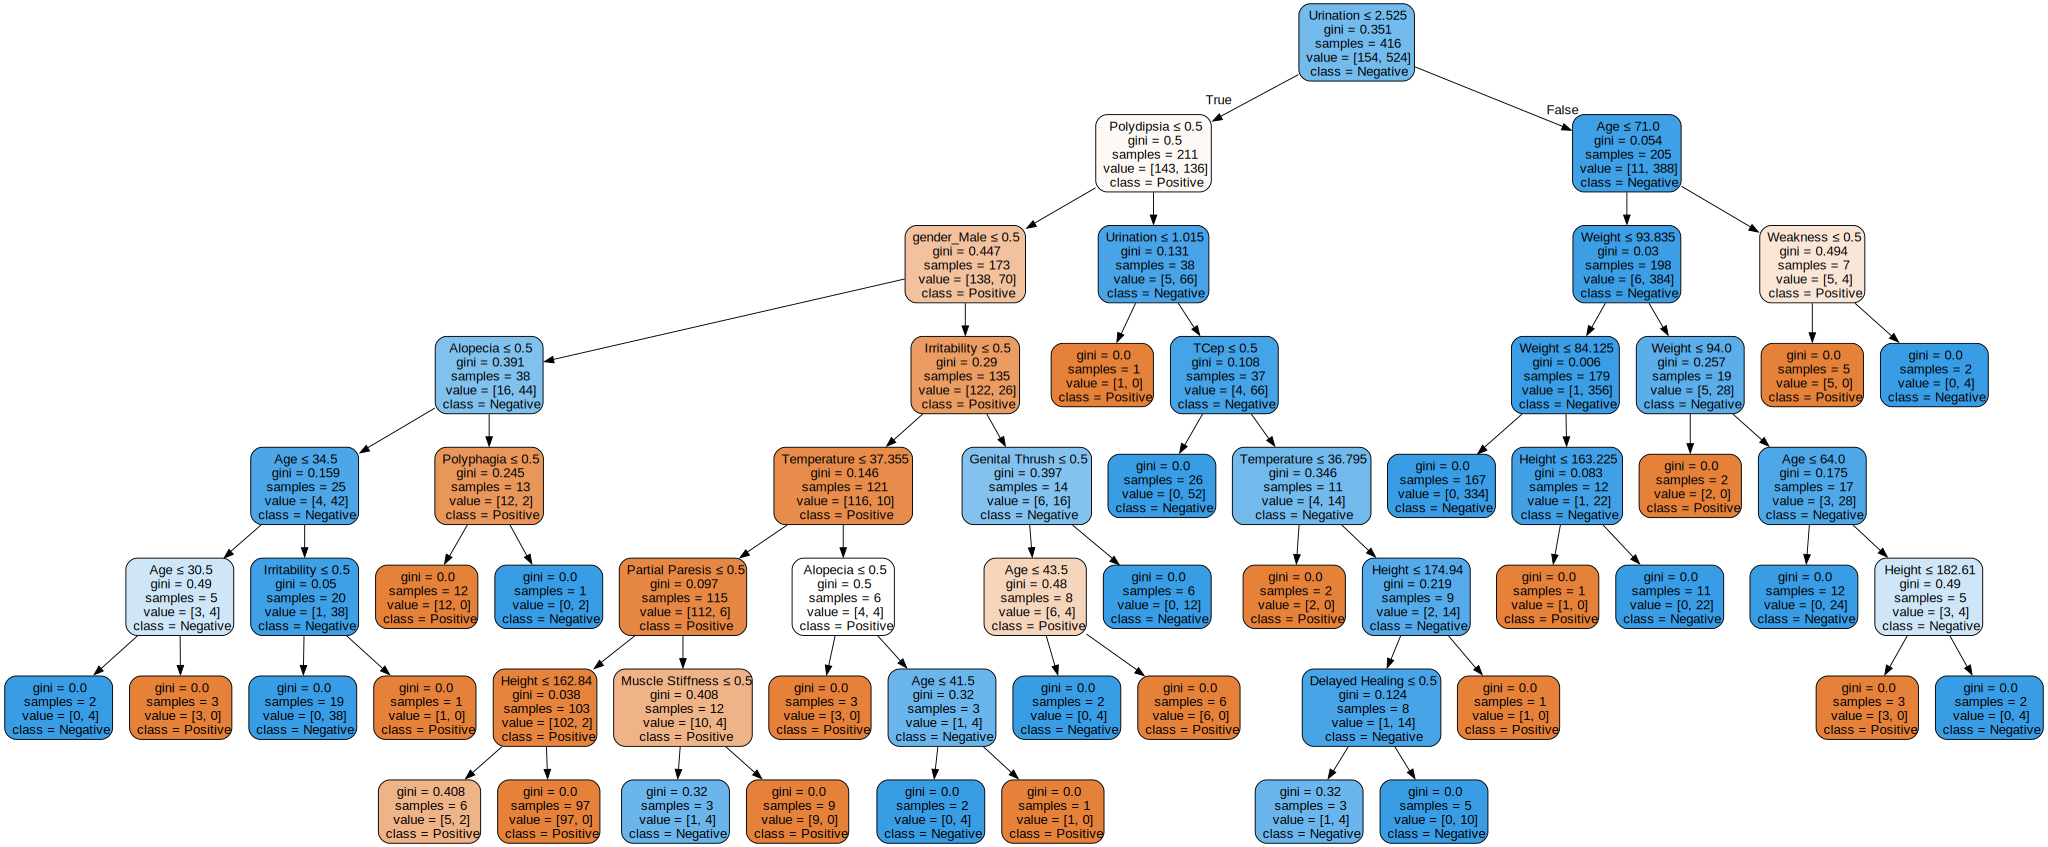

In [38]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                      feature_names=selected_features,
                      class_names= ['Positive', 'Negative'], # this parameter doesen't seem to work
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
# Make Pdf
#graph.render("Diabetes")
graph

In [39]:
# Training accuracy
from sklearn import metrics
y_train_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_train_pred)

0.9927884615384616

In [40]:
y_test_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_test_pred)

0.9134615384615384

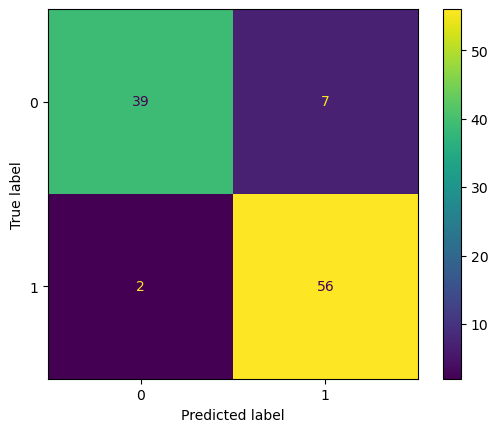

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()

In [42]:
X_test_plot = X_test.copy()
X_test_plot['error'] = y_test > y_test_pred
#g = sns.pairplot(X_test_plot.drop(binary_features, axis=1), hue='error')

### Some Pruning

Code borrowed from https://www.kaggle.com/code/arunmohan003/pruning-decision-trees-tutorial

In [43]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf_tmp = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,class_weight=weight if use_weights else None)
    clf_tmp.fit(X_train, y_train)
    clfs.append(clf_tmp)

[0.         0.00039331 0.00147079 0.00157217 0.00235988 0.00240905
 0.00284945 0.00287422 0.00353982 0.00362131 0.00394958 0.00432651
 0.00445851 0.00505689 0.00643604 0.00655523 0.00757176 0.01878134
 0.02319306 0.03916384 0.05491415 0.11391686]


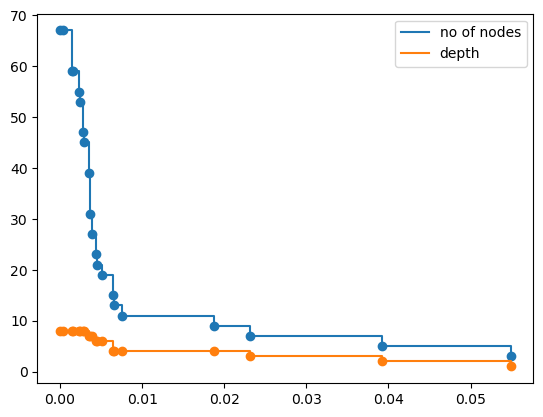

In [44]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import accuracy_score,confusion_matrix
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()


In [46]:
alpha = 0.02
classes = ['Negative', 'Positive']
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=alpha,class_weight=weight if use_weights else None)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')


Train score 0.8966346153846154
Test score 0.8653846153846154


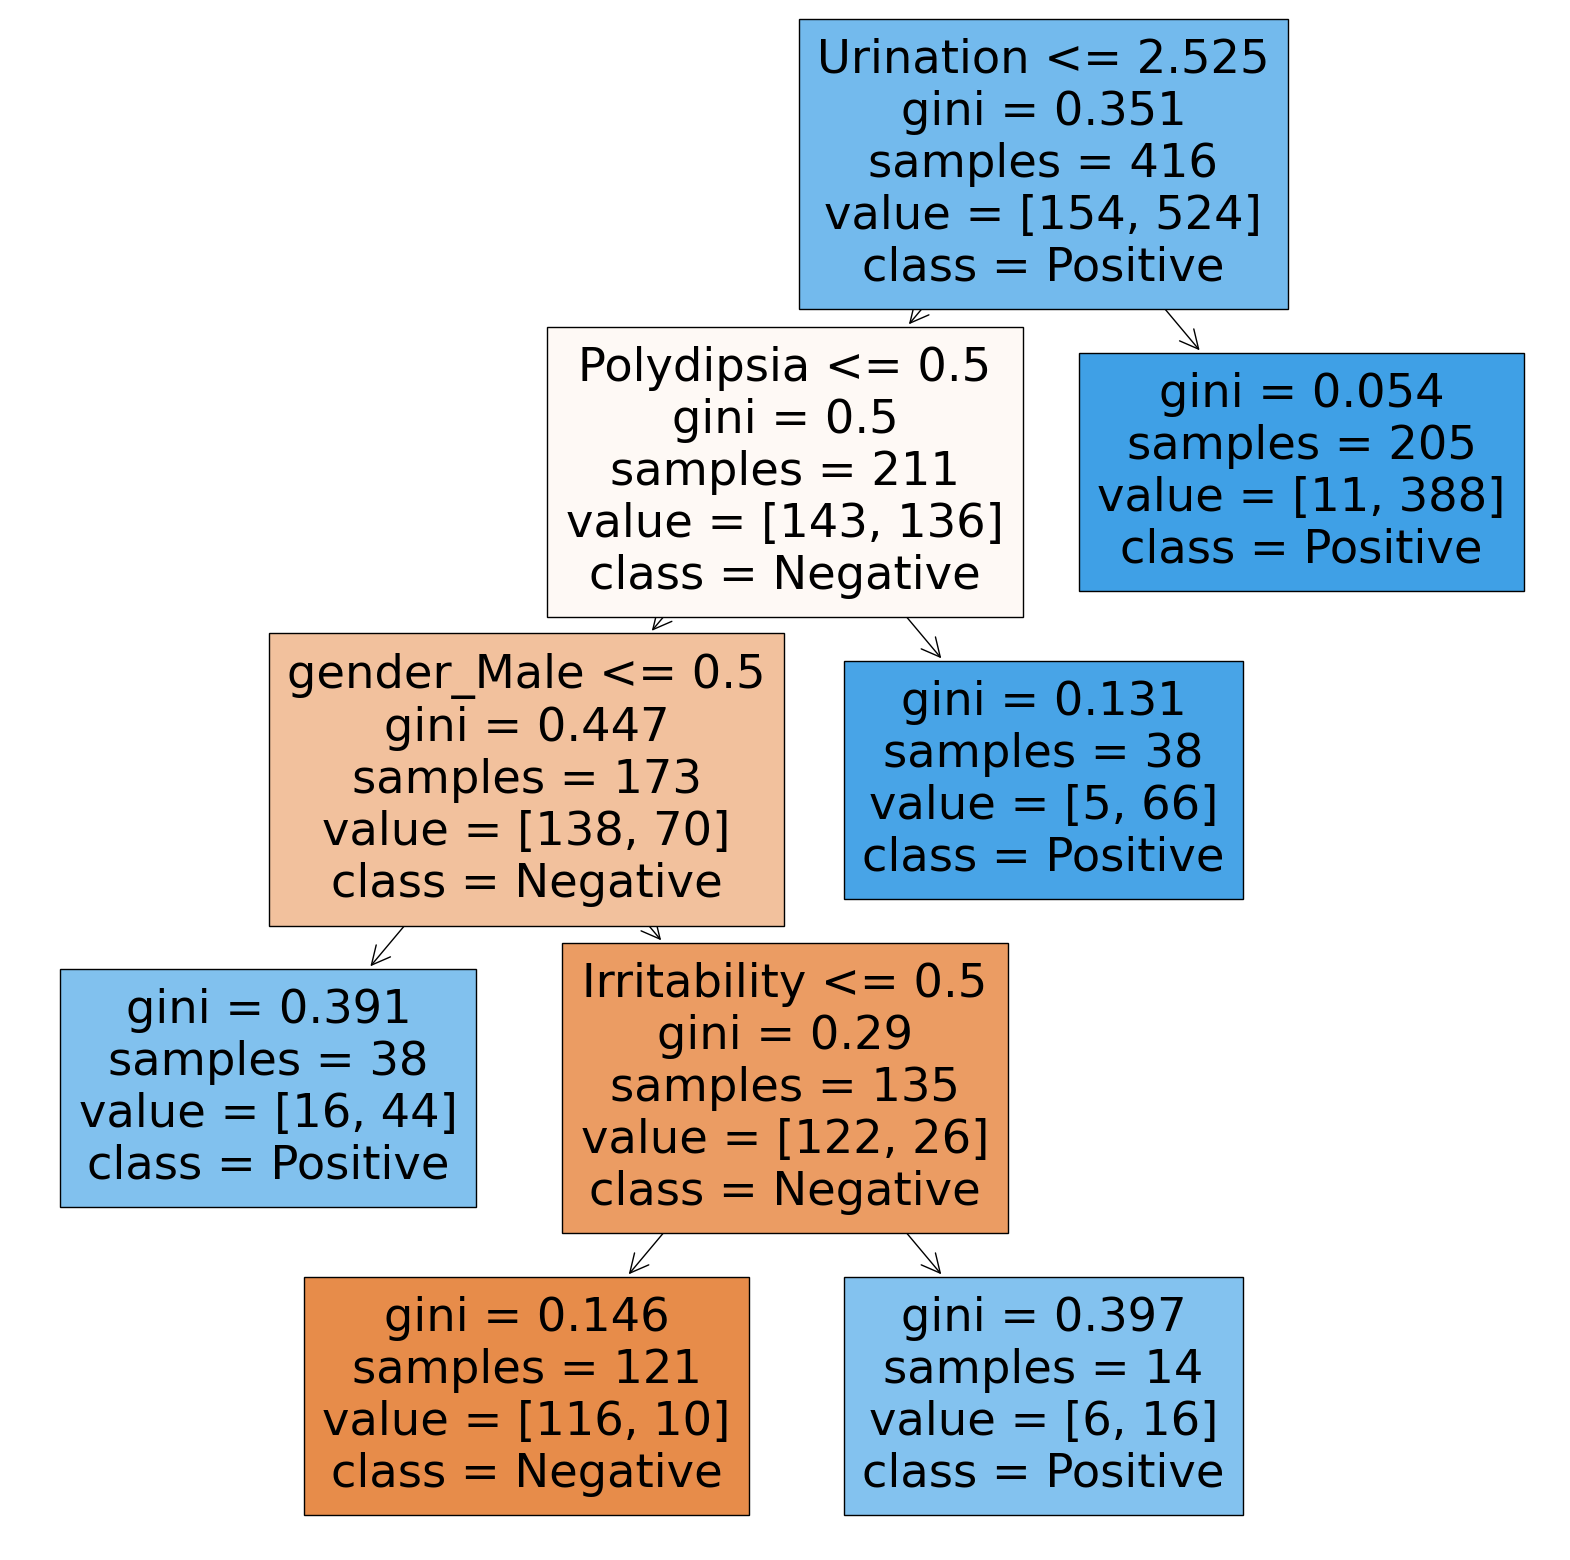

In [47]:
plt.figure(figsize=(20,20))
features = selected_features
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True)
plt.show()

Logistic regression with C = 10.00. cv score: 0.9255306942053929
Logistic regression with C = 7.85. cv score: 0.9255306942053929
Logistic regression with C = 6.16. cv score: 0.9231210556511762
Logistic regression with C = 4.83. cv score: 0.9207114170969593
Logistic regression with C = 3.79. cv score: 0.9207114170969593
Logistic regression with C = 2.98. cv score: 0.9231210556511762
Logistic regression with C = 2.34. cv score: 0.9207114170969593
Logistic regression with C = 1.83. cv score: 0.9183017785427424
Logistic regression with C = 1.44. cv score: 0.9207114170969593
Logistic regression with C = 1.13. cv score: 0.9183017785427424
Logistic regression with C = 0.89. cv score: 0.9207401032702236
Logistic regression with C = 0.70. cv score: 0.9207401032702236
Logistic regression with C = 0.55. cv score: 0.9207401032702236
Logistic regression with C = 0.43. cv score: 0.9207401032702236
Logistic regression with C = 0.34. cv score: 0.9255306942053929
Logistic regression with C = 0.26. cv s

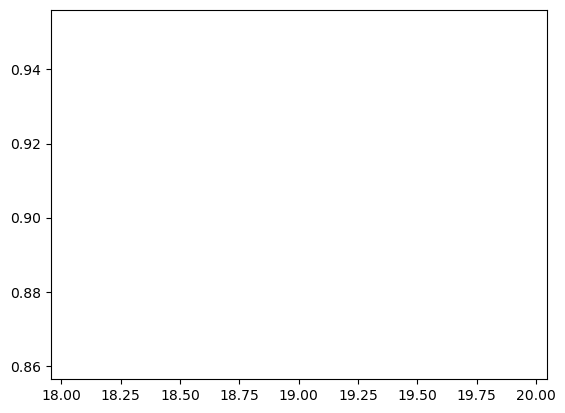

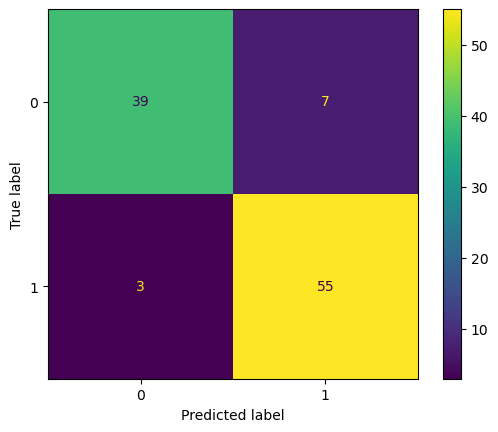

In [48]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1', solver='liblinear', C=1000)

cs = 1/np.geomspace(0.1, 10, 20)

scores = {}


for c in cs:
    clf_cv = LogisticRegression(penalty='l2', solver='liblinear', C=c)
    score = cross_val_score(clf_cv, X_train, y_train, cv=5).mean()
    scores[d] = score
    print(f'Logistic regression with C = {c:.2f}. cv score: {score}')

print(scores.values())

plt.plot(scores.keys(), scores.values())



clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

# Accuracy
print(metrics.accuracy_score(y_test, y_test_pred))
print(clf.coef_)

# Confusion Matrix
confusion_mat = metrics.confusion_matrix(y_test, y_test_pred)
con_mat_disp = ConfusionMatrixDisplay(confusion_mat, display_labels=clf.classes_)
con_mat_disp.plot()


In [49]:
metrics.accuracy_score(y_test, y_test_pred)

0.9038461538461539